# Sanovo assignment

Problem:
* Predict the start of the snowbal effect of lanes stopping. 

Expected data needed to solve:
- lane stopping data
- error data of lanes
- infeed data
- outfeed data

Ideal outcome:
- Knowing which error mostly causes the snowbal effect OR which combination of erros causes a snowball effect. The model is able to predict this.

Treatment:
- Early warning system

## Start with data exploration

Data from 1 machine:
- csv data with lanes errors 
- csv eventdata based machine errors  
- mongo db with all outputted egg cartons 

In [2]:
import pandas as pd

data = pd.read_csv('/Users/tyco/Desktop/MADS/sanovo/data/raw/HSTMachineError.csv')
data.head(5)

,MerId,MerType,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority
0,11897185,7,2025-01-30 10:22:00.000,10,22,181.0,180.0,90.0,NaN,NaN,4620,NaN,0,0,0
1,11897186,21,2025-01-30 10:21:42.000,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0
2,11897187,23,2025-01-30 10:21:56.000,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
3,11897188,21,2025-01-30 10:21:56.000,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0
4,11897189,23,2025-01-30 10:21:57.000,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0


In [3]:
# Set pandas display option to show 1000 rows
pd.set_option('display.max_rows', 1000)

# Reset the display option to default (optional)
# pd.reset_option('display.max_rows')

In [4]:
data.dtypes

MerId                int64
MerType              int64
MerDate             object
MerNumber            int64
MerSubNumber         int64
MerData1           float64
MerData2           float64
MerData3           float64
MerData4           float64
MerData5           float64
MerMinId             int64
MerText            float64
MerDeviceType        int64
MerDeviceNumber      int64
MerPriority          int64
dtype: object

In [5]:
# data[(data['MerType'] == 1)]
data['MerType'].unique()

array([ 7, 21, 23, 22, 15,  8, 24])

In [6]:
data['MerDate'].min(), data['MerDate'].max()

('2025-01-30 10:21:42.000', '2025-04-08 21:10:01.000')

In [7]:
data[(data['MerType'] == 8)]

,MerId,MerType,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority
202,11897387,8,2025-01-30 10:25:46.000,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
206,11897391,8,2025-01-30 10:25:48.000,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
401,11897586,8,2025-01-30 10:31:04.000,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
406,11897592,8,2025-01-30 10:31:10.000,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
427,11897613,8,2025-01-30 10:31:15.000,0,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043293,14027540,8,2025-04-08 20:06:50.000,0,3,0.0,191.0,1.0,0.0,0.0,4620,NaN,1,0,0
2043306,14027553,8,2025-04-08 20:06:55.000,1,3,0.0,191.0,1.0,0.0,0.0,4620,NaN,1,0,0
2043317,14027564,8,2025-04-08 20:07:30.000,0,3,0.0,191.0,1.0,0.0,0.0,4620,NaN,1,0,0
2043331,14027578,8,2025-04-08 20:07:40.000,1,3,0.0,191.0,1.0,0.0,0.0,4620,NaN,1,0,0


- Each event has a MerNumber, which describes the error, and a MerDate, which represents the timestamp of occurrence.
- The attached PDF "Grader Errors and Warnings" provides details on all errors.
- MerNumber ≥ 400 indicates a lane error, while MerNumber < 400 represents a machine error.
- MerType specifies whether the error occurs (code 21 or 22) or when the error is resolved (code 23 or 24).
- There are other MerType values—refer to the "Grader Performance Calculation" PDF for an explanation of these fields.
- MerType 8 represents a message related to the machine stopping or starting, including the reason for the stop.
- Lane Pressure Control should contain the lane number that caused the machine to stop.
- MerSubnumber indicates the lane number where the issue occurred if MerNumber ≥ 400.
- MerSubnumber may have a different meaning if MerNumber < 400.
- MerData1, MerData2, MerData3, MerData4 provide additional information about the error.

Given the following information, we are only interested in lane information (MerNumber ≥ 400 & MerSubnumber contains lanenumber) and if an error is started or resolved (MerType 21-24) and if the machine stops (MerType 8).

In [8]:
# Create a copy of the data
data_copy = data.copy()

In [9]:
#filter data
data_filtered = data_copy[(data_copy['MerNumber'] >= 400) & (data_copy['MerType'].between(21, 24)) | (data_copy['MerType'] == 8)]

#create error column
data_filtered['Error'] = data_filtered['MerType'].apply(lambda x: 1 if x in [21, 22] else 0)

#renmane column 
data_filtered = data_filtered.rename(columns={'MerSubNumber': 'LaneNumber'})

data_filtered.head(5)

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/1294131841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Error'] = data_filtered['MerType'].apply(lambda x: 1 if x in [21, 22] else 0)


,MerId,MerType,MerDate,MerNumber,LaneNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error
1,11897186,21,2025-01-30 10:21:42.000,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,1
2,11897187,23,2025-01-30 10:21:56.000,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0
3,11897188,21,2025-01-30 10:21:56.000,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,1
4,11897189,23,2025-01-30 10:21:57.000,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0
5,11897190,21,2025-01-30 10:21:57.000,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,1


The data is pretty large because it is event based. We want to make timeline for this so we need to fill this in per second. Therefore we start with 1 day. 

In [10]:
# Filter data_filtered to only include records for the date 2025-01-30
data_filtered['MerDate'] = pd.to_datetime(data_filtered['MerDate'])
data_filtered_2025_01_30 = data_filtered[data_filtered['MerDate'].dt.date == pd.to_datetime('2025-01-30').date()]

# check dates
data_filtered_2025_01_30['MerDate'].min(), data_filtered_2025_01_30['MerDate'].max()

# Assume 'LaneNumber' is the group key and 'MerDate' is the datetime column
full_datetime_index = pd.date_range(start='2025-01-30 00:00:00', end='2025-01-30 23:59:59', freq='s')
full_datetime_df = pd.DataFrame({'MerDate': full_datetime_index})

data_filled = pd.merge(full_datetime_df, data_filtered_2025_01_30, how='left', on='MerDate')

# We want this data to be forward filled. This way I think it is easier to visualise. 

# test = data_filled[(data_filled['MerDate'] >= '2025-01-30 10:21:40') & (data_filled['MerDate'] <= '2025-01-30 10:23:00')]
# test
data_filled = data_filled.ffill()

In [11]:
data_filled[(data_filled['MerDate'] >= '2025-01-30 10:21:40') & (data_filled['MerDate'] <= '2025-01-30 10:23:00')]

,MerDate,MerId,MerType,MerNumber,LaneNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error
37300,2025-01-30 10:21:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37301,2025-01-30 10:21:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37302,2025-01-30 10:21:42,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37303,2025-01-30 10:21:43,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37304,2025-01-30 10:21:44,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37305,2025-01-30 10:21:45,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37306,2025-01-30 10:21:46,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37307,2025-01-30 10:21:47,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37308,2025-01-30 10:21:48,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
37309,2025-01-30 10:21:49,11897186.0,21.0,460.0,12.0,1.0,22.0,41.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0


We now convert the lane numbers to whole numbers again

In [12]:
data_filled['LaneNumber'] = data_filled['LaneNumber'].fillna(0).astype(int)
data_filled

,MerDate,MerId,MerType,MerNumber,LaneNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error
0,2025-01-30 00:00:00,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-30 00:00:01,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-30 00:00:02,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-30 00:00:03,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-30 00:00:04,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88817,2025-01-30 23:59:55,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
88818,2025-01-30 23:59:56,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
88819,2025-01-30 23:59:57,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0
88820,2025-01-30 23:59:58,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0


We want to split the date and timestamp in seperate columns as well for visualising purposes later

In [13]:
data_filled['Date'] = data_filled['MerDate'].astype(str).str[:10]
data_filled['Time'] = data_filled['MerDate'].astype(str).str[11:]
data_filled['LaneString'] = data_filled['LaneNumber'].astype(str)
data_filled

,MerDate,MerId,MerType,MerNumber,LaneNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error,Date,Time,LaneString
0,2025-01-30 00:00:00,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-30,00:00:00,0
1,2025-01-30 00:00:01,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-30,00:00:01,0
2,2025-01-30 00:00:02,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-30,00:00:02,0
3,2025-01-30 00:00:03,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-30,00:00:03,0
4,2025-01-30 00:00:04,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-30,00:00:04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88817,2025-01-30 23:59:55,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0,2025-01-30,23:59:55,7
88818,2025-01-30 23:59:56,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0,2025-01-30,23:59:56,7
88819,2025-01-30 23:59:57,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0,2025-01-30,23:59:57,7
88820,2025-01-30 23:59:58,11922423.0,22.0,490.0,7,0.0,12.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.0,2025-01-30,23:59:58,7


In [14]:
data_filled.dtypes

MerDate            datetime64[ns]
MerId                     float64
MerType                   float64
MerNumber                 float64
LaneNumber                  int64
MerData1                  float64
MerData2                  float64
MerData3                  float64
MerData4                  float64
MerData5                  float64
MerMinId                  float64
MerText                   float64
MerDeviceType             float64
MerDeviceNumber           float64
MerPriority               float64
Error                     float64
Date                       object
Time                       object
LaneString                 object
dtype: object

In [15]:
# Lets visualise lane number 2
lane_2 = data_filled[(data_filled['LaneNumber'] == 2)]

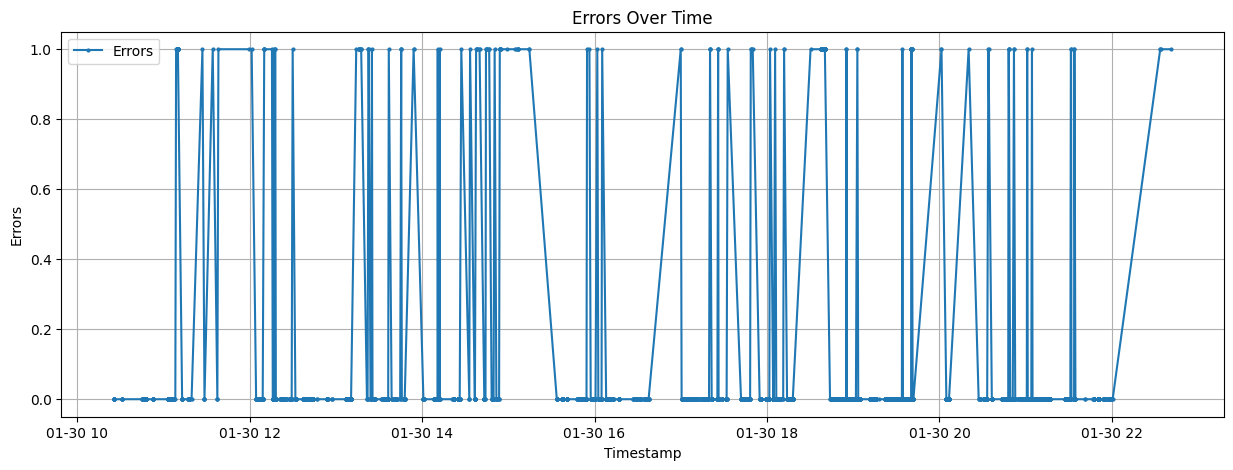

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(lane_2['MerDate'], lane_2['Error'], marker='o', linestyle='-', markersize=2, label='Errors')
plt.xlabel('Timestamp')
plt.ylabel('Errors')
plt.title('Errors Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# lets filter the data for a specific day
data_filled_day = data_filled[data_filled['Date'] == pd.to_datetime('2025-01-30').date()]

Filter for 1 day to keep performance up

In [18]:
data_filled_day = data_filled[data_filled['Date'] == '2025-01-30']


In [19]:
data_filled_day['Date'].unique()

array(['2025-01-30'], dtype=object)

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/4142162575.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


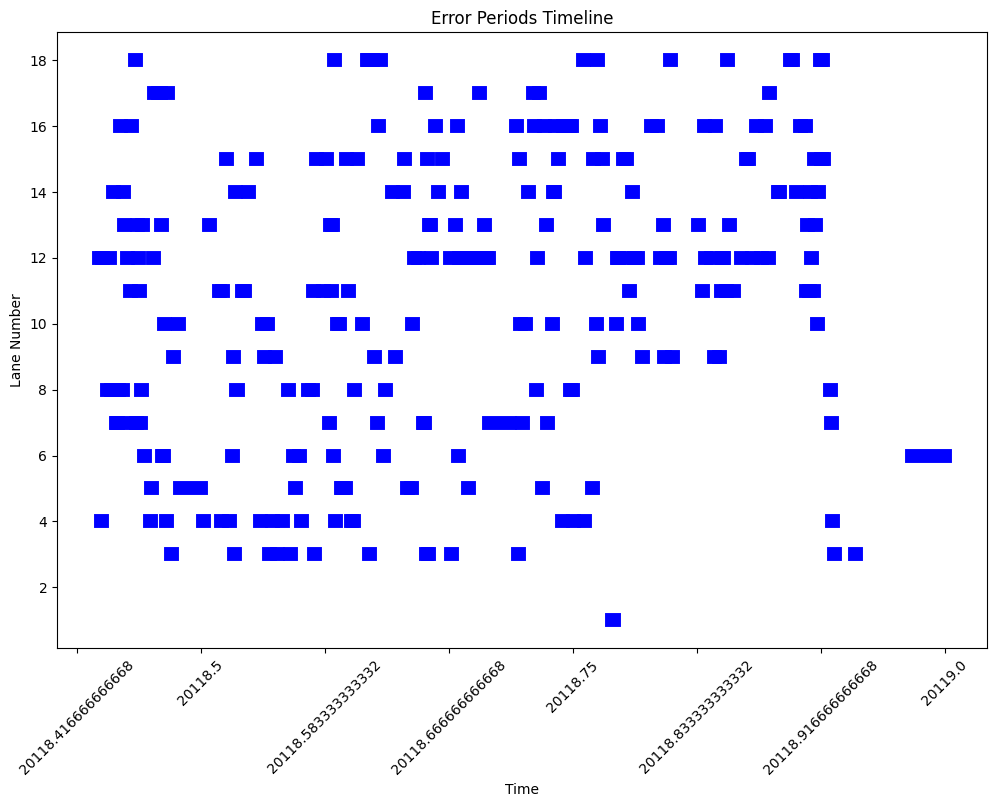

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_lanes(df):
    # Identify error periods
    start_time = None
    boxes = []

    for index, row in df.iterrows():
        if row['Error'] == 1 and start_time is None:
            start_time = row['MerDate']
            lane = row['LaneNumber']
        elif row['Error'] == 0 and start_time is not None:
            boxes.append((start_time, row['MerDate'], lane))
            start_time = None

    # Handle case where error continues till the end
    if start_time is not None:
        boxes.append((start_time, df['MerDate'].iloc[-1], lane))

    # Plotting
    fig, ax = plt.subplots(figsize = (12,8))

    for start, end, lane in boxes:
        ax.plot([start, end], [lane, lane], color='blue', linewidth=10)

    # ax.set_xlim(df['Time'].min(), df['Time'].max())
    # ax.set_ylim(df['LaneNumber'].min() - 1, df['LaneNumber'].max() + 1)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Lane Number')
    ax.set_title('Error Periods Timeline')

    plt.show()
    # print(boxes)

plot_lanes(data_filled_day)

The plot is not very good readable yet. Maybe we can try to filter down even more, like for say in 1 hour.

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/4142162575.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


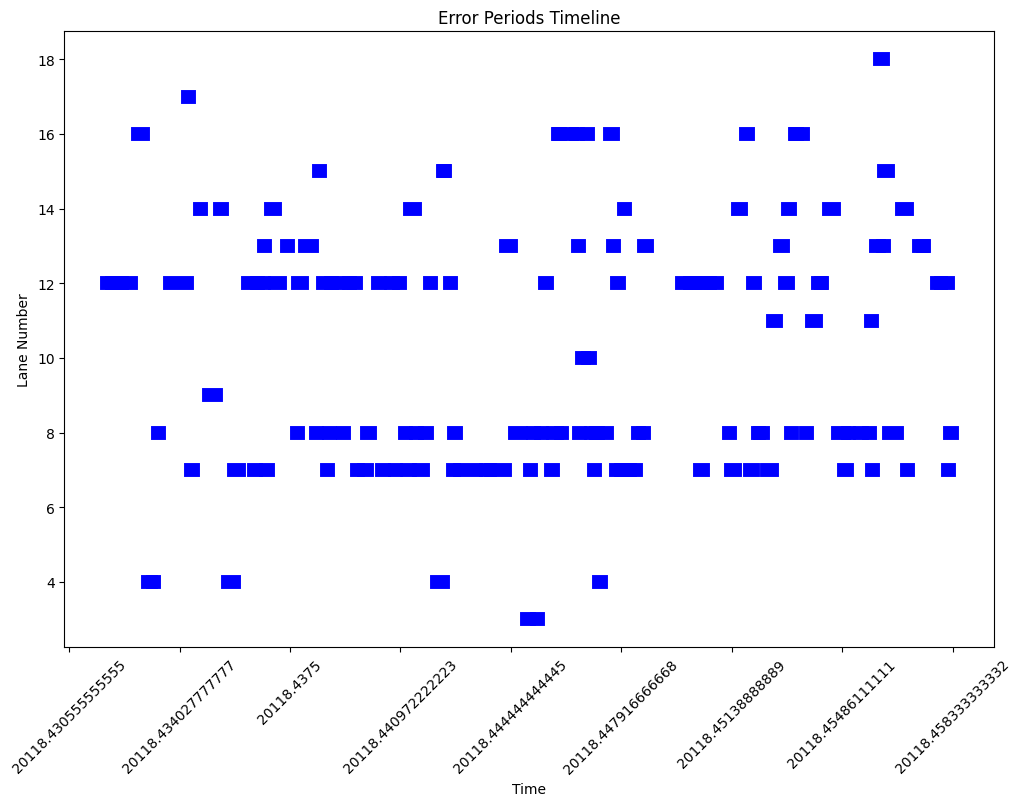

In [21]:
# Filter data_filled_day for a specific 1-hour range, e.g., from 10:00:00 to 11:00:00
start_time = '10:00:00'
end_time = '11:00:00'

data_filled_hour = data_filled_day[
    (data_filled_day['MerDate'] >= f"2025-01-30 {start_time}") &
    (data_filled_day['MerDate'] < f"2025-01-30 {end_time}")
]

plot_lanes(data_filled_hour)

maybe even take 10 minutes

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/4142162575.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


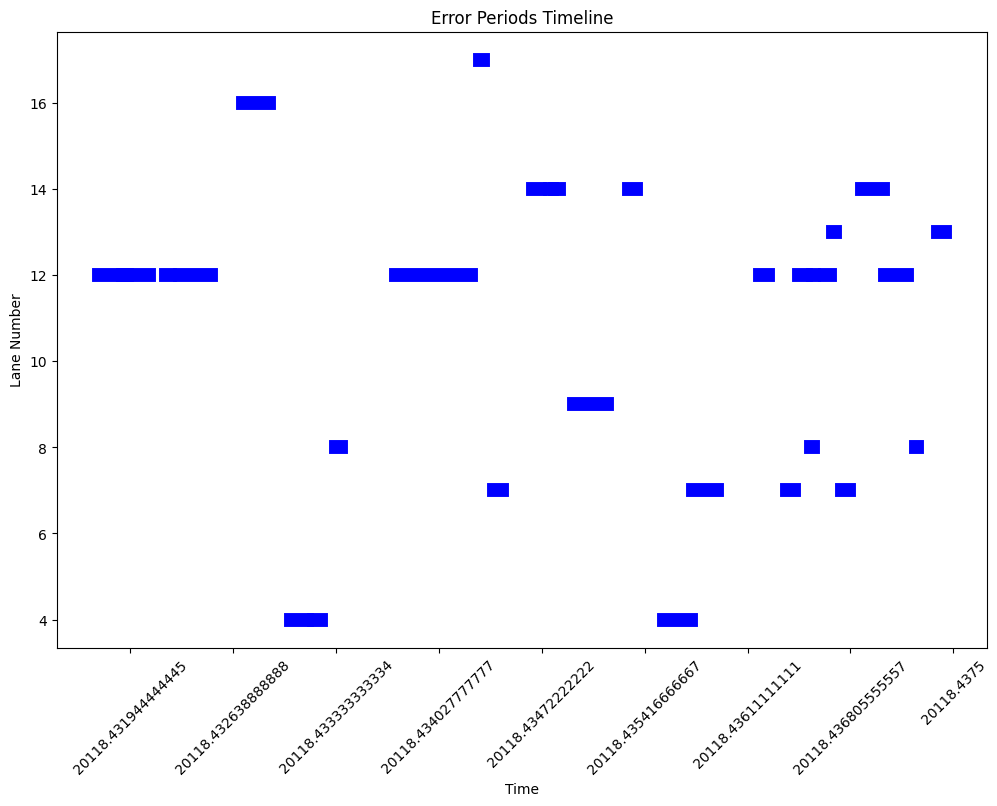

In [22]:
# Filter data_filled_day for a specific 1-hour range, e.g., from 10:00:00 to 11:00:00
start_time = '10:00:00'
end_time = '10:30:00'

data_filled_minutes = data_filled_day[
    (data_filled_day['MerDate'] >= f"2025-01-30 {start_time}") &
    (data_filled_day['MerDate'] < f"2025-01-30 {end_time}")
]

plot_lanes(data_filled_minutes)

In [23]:
data_filled_minutes['MerDate'].min(), data_filled_minutes['MerDate'].max()

(Timestamp('2025-01-30 10:00:00'), Timestamp('2025-01-30 10:29:59'))

In [24]:
data_filled_day[data_filled_day['MerType'] == 8]

,MerDate,MerId,MerType,MerNumber,LaneNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Error,Date,Time,LaneString
37551,2025-01-30 10:25:46,11897387.0,8.0,0.0,2,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,10:25:46,2
37552,2025-01-30 10:25:47,11897387.0,8.0,0.0,2,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,10:25:47,2
37553,2025-01-30 10:25:48,11897391.0,8.0,1.0,2,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,10:25:48,2
37554,2025-01-30 10:25:49,11897391.0,8.0,1.0,2,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,10:25:49,2
37555,2025-01-30 10:25:50,11897391.0,8.0,1.0,2,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,10:25:50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86923,2025-01-30 23:28:21,11922414.0,8.0,0.0,4,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,23:28:21,4
86924,2025-01-30 23:28:22,11922414.0,8.0,0.0,4,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,23:28:22,4
86925,2025-01-30 23:28:23,11922414.0,8.0,0.0,4,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,23:28:23,4
86926,2025-01-30 23:28:24,11922414.0,8.0,0.0,4,0.0,0.0,0.0,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.0,2025-01-30,23:28:24,4


21 error raised
23 error removed

use error removed to predict error raised

Jim thinks if we predict this with a neural network it will catch the complexity of different lanes errors causing machine stops

# Sequence of errors before stop

We need to transform the data in such a way that the status of the machine is known and that we are able to zoom in on a period right before a machine stop.

In [25]:
df = data_copy[(data_copy['MerNumber'] >= 400) & (data_copy['MerType'].between(21, 24)) | (data_copy['MerType'] == 8)]

In [26]:
df['Machine_stop'] = df.apply(lambda row: 1 if row['MerType'] == 8 and row['MerNumber'] == 1 else 0, axis=1)

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/1142402122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Machine_stop'] = df.apply(lambda row: 1 if row['MerType'] == 8 and row['MerNumber'] == 1 else 0, axis=1)


In [38]:
df['MerDate'] = pd.to_datetime(df['MerDate'])
filtered_df = df[df['MerDate'].dt.date == pd.to_datetime('2025-01-30').date()]

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/2691510066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MerDate'] = pd.to_datetime(df['MerDate'])


In [102]:
# filtered_df.head(5)
filtered_df[filtered_df['Machine_stop'] == 1]

,MerId,MerType,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Machine_stop
206,11897391,8,2025-01-30 10:25:48,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
406,11897592,8,2025-01-30 10:31:10,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
433,11897619,8,2025-01-30 10:31:17,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1232,11898418,8,2025-01-30 10:45:52,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1251,11898437,8,2025-01-30 10:46:59,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1440,11898626,8,2025-01-30 10:52:50,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1469,11898655,8,2025-01-30 10:52:58,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1758,11898944,8,2025-01-30 11:03:35,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1794,11898980,8,2025-01-30 11:04:20,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1
1807,11898993,8,2025-01-30 11:04:27,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1


In [87]:
filtered_df.describe()

,MerId,MerType,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Machine_stop
count,1.019300e+04,10193.000000,10193,10193.000000,10193.000000,10193.000000,10193.000000,10193.000000,0.0,0.0,10193.0,0.0,10193.0,10193.0,10193.0,10193.000000
mean,1.190855e+07,20.848818,2025-01-30 15:36:12.630825216,408.259001,9.494751,0.049740,5.119788,0.556755,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.048465
min,1.189719e+07,8.000000,2025-01-30 10:21:42,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.000000
25%,1.190301e+07,21.000000,2025-01-30 12:54:37,414.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.000000
50%,1.190759e+07,22.000000,2025-01-30 14:52:17,456.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.000000
75%,1.191440e+07,23.000000,2025-01-30 18:14:57,461.000000,14.000000,0.000000,11.000000,0.000000,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,0.000000
max,1.192242e+07,23.000000,2025-01-30 23:28:31,490.000000,18.000000,4.000000,24.000000,42.000000,NaN,NaN,4620.0,NaN,0.0,0.0,0.0,1.000000
std,6.891498e+03,4.278658,NaN,136.120533,5.023375,0.256352,6.064271,4.438656,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.214756


In [95]:
df['MerType_21'] = (df['MerType'] == 21).astype(int)
df['MerType_23'] = (df['MerType'] == 23).astype(int)
df = df.drop(columns = 'MerType')
df.head()

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/3597552065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MerType_21'] = (df['MerType'] == 21).astype(int)
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/3597552065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MerType_23'] = (df['MerType'] == 23).astype(int)


,MerId,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Machine_stop,MerType_21,MerType_23
1,11897186,2025-01-30 10:21:42,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,0,1,0
2,11897187,2025-01-30 10:21:56,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,0,1
3,11897188,2025-01-30 10:21:56,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,0,1,0
4,11897189,2025-01-30 10:21:57,460,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,0,1
5,11897190,2025-01-30 10:21:57,460,12,1.0,22.0,41.0,NaN,NaN,4620,NaN,0,0,0,0,1,0



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    132614
           1       1.00      1.00      1.00      4992

    accuracy                           1.00    137606
   macro avg       1.00      1.00      1.00    137606
weighted avg       1.00      1.00      1.00    137606



ValueError: Shape of passed values is (137606, 1), indices imply (137606, 76)

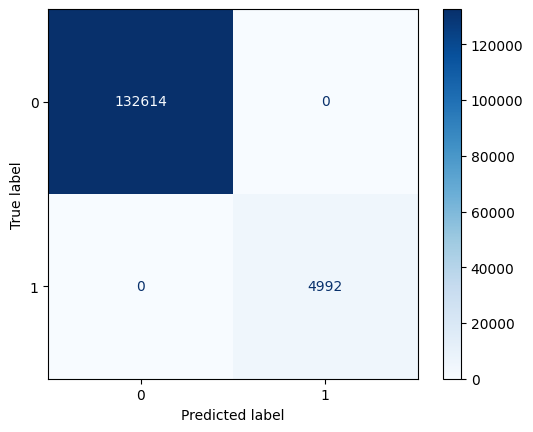

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# Define categorical and numerical columns
categorical_columns = ['MerDeviceType', 'MerDeviceNumber', 'MerPriority','MerNumber', 'MerSubNumber']
numerical_columns = ['MerData1', 'MerData2', 'MerData3']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Select features and target
X = df.drop(columns=['Machine_stop', 'MerDate', 'MerId', 'MerData4', 'MerData5', 'MerText'])
y = df['Machine_stop']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model using confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['classifier'].classes_)
disp.plot(cmap='Blues')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Access the preprocessed data from the pipeline
preprocessed_data = pipeline.named_steps['preprocessor'].transform(X_test)

# Convert the preprocessed data to a DataFrame for better readability
preprocessed_df = pd.DataFrame(preprocessed_data, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())

# Display the preprocessed DataFrame
preprocessed_df.head()

# # Access the RandomForestClassifier from the pipeline
# rf_classifier = pipeline.named_steps['classifier']

# # Print feature importance
# feature_importances = rf_classifier.feature_importances_
# feature_names = X.columns
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# print("\nFeature Importances:")
# print(importance_df)

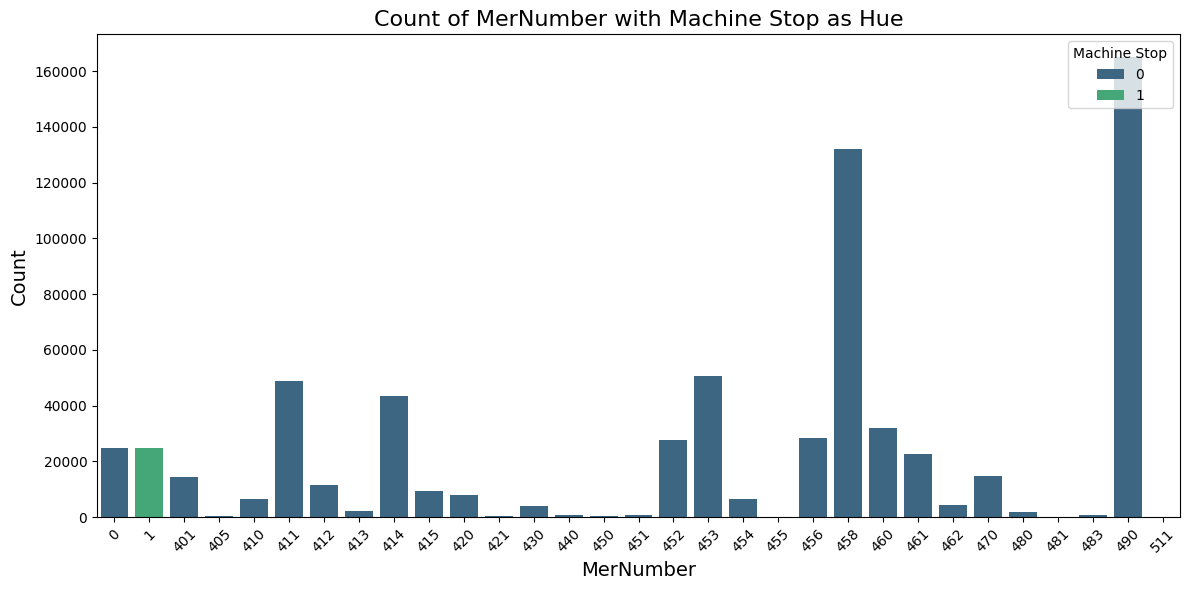

In [97]:
import seaborn as sns

import matplotlib.pyplot as plt

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='MerNumber', hue='Machine_stop', palette='viridis')

# Customize the plot
plt.title('Count of MerNumber with Machine Stop as Hue', fontsize=16)
plt.xlabel('MerNumber', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Machine Stop', loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

In [98]:
df[df['MerNumber'] == 1]

,MerId,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Machine_stop,MerType_21,MerType_23
206,11897391,2025-01-30 10:25:48,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1,0,0
406,11897592,2025-01-30 10:31:10,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1,0,0
433,11897619,2025-01-30 10:31:17,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1,0,0
1232,11898418,2025-01-30 10:45:52,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1,0,0
1251,11898437,2025-01-30 10:46:59,1,2,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043270,14027517,2025-04-08 20:06:19,1,2,0.0,96.0,18.0,0.0,0.0,4620,NaN,1,0,0,1,0,0
2043278,14027525,2025-04-08 20:06:26,1,2,0.0,96.0,18.0,0.0,0.0,4620,NaN,1,0,0,1,0,0
2043288,14027535,2025-04-08 20:06:34,1,2,0.0,96.0,18.0,0.0,0.0,4620,NaN,1,0,0,1,0,0
2043306,14027553,2025-04-08 20:06:55,1,3,0.0,191.0,1.0,0.0,0.0,4620,NaN,1,0,0,1,0,0


In [59]:
# Filter data_filled_day for a specific 1-hour range, e.g., from 10:00:00 to 11:00:00
start_time = '10:31:00'
end_time = '10:32:00'

filtered_df_hour = filtered_df[
    (filtered_df['MerDate'] >= f"2025-01-30 {start_time}") &
    (filtered_df['MerDate'] < f"2025-01-30 {end_time}")
]

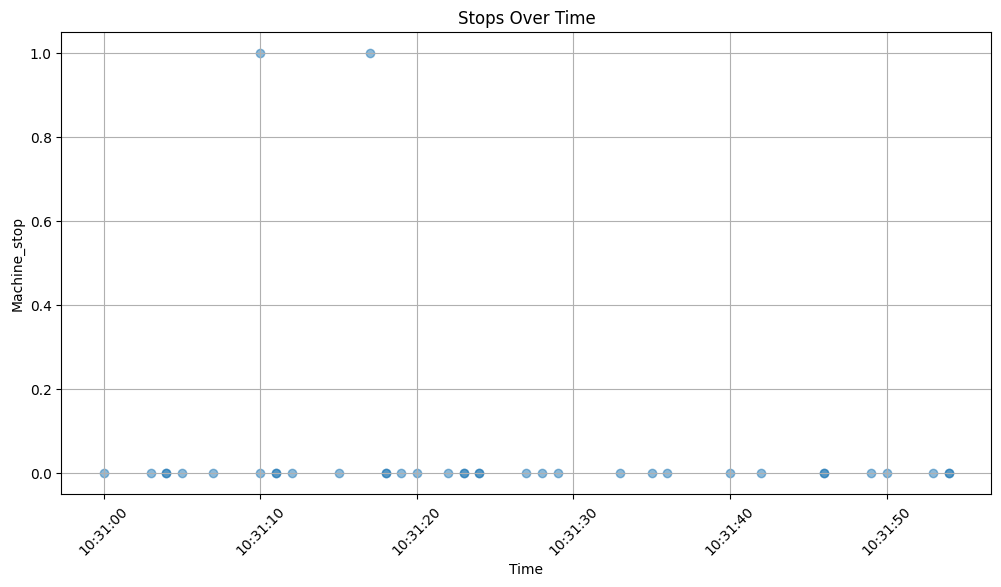

In [60]:
import matplotlib.pyplot as plt

def plot_scatter(df, y_column, title="Scatter Plot"):
    """
    Plots a scatterplot with time on the x-axis and the specified column on the y-axis.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    y_column (str): The column name to be plotted on the y-axis.
    title (str): The title of the plot (default is "Scatter Plot").
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(df['MerDate'], df[y_column], alpha=0.5)
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.ylabel(y_column)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage:
plot_scatter(filtered_df_hour, 'Machine_stop', title="Stops Over Time")

In [72]:
from datetime import timedelta
window_seconds = 30  # Look back 30 seconds

# Loop over all rows where the machine stopped
stop_rows = filtered_df[filtered_df['Machine_stop'] == 1]

snapshot_counter = 1  # Initialize snapshot counter

# Create a dataframe to store 30-second snapshots before machine stops
snapshot_data = []

# Loop over all rows where the machine stopped
for idx, stop_row in stop_rows.iterrows():
    stop_time = stop_row['MerDate']

    # Get rows in the 30-second window before the stop
    mask = (filtered_df['MerDate'] <= stop_time) & (filtered_df['MerDate'] >= stop_time - timedelta(seconds=window_seconds))
    window = filtered_df[mask]

    # Skip if window is empty
    if window.empty:
        continue

    # Add a column to indicate the snapshot number
    window['snapshot'] = snapshot_counter

    # Append the window to the snapshot data
    snapshot_data.append(window)

    # Increment the snapshot counter
    snapshot_counter += 1

# Combine all snapshots into a single dataframe
snapshot_df = pd.concat(snapshot_data, ignore_index=True)
snapshot_df

/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/4222716227.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window['snapshot'] = snapshot_counter
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/4222716227.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window['snapshot'] = snapshot_counter
/var/folders/pt/00xl4yzd64s0vbx9w9tzh94m0000gn/T/ipykernel_43497/4222716227.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

,MerId,MerType,MerDate,MerNumber,MerSubNumber,MerData1,MerData2,MerData3,MerData4,MerData5,MerMinId,MerText,MerDeviceType,MerDeviceNumber,MerPriority,Machine_stop,snapshot
0,11897328,23,2025-01-30 10:25:19,453,12,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,1
1,11897339,22,2025-01-30 10:25:24,490,17,0.0,11.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,1
2,11897349,23,2025-01-30 10:25:26,490,7,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,1
3,11897368,22,2025-01-30 10:25:32,490,7,0.0,12.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,1
4,11897370,21,2025-01-30 10:25:33,452,16,0.0,0.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5924,11922310,21,2025-01-30 22:41:03,411,5,0.0,11.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,494
5925,11922313,21,2025-01-30 22:41:03,411,6,0.0,11.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,494
5926,11922314,21,2025-01-30 22:41:03,411,7,0.0,11.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,494
5927,11922316,22,2025-01-30 22:41:03,490,8,0.0,12.0,0.0,NaN,NaN,4620,NaN,0,0,0,0,494


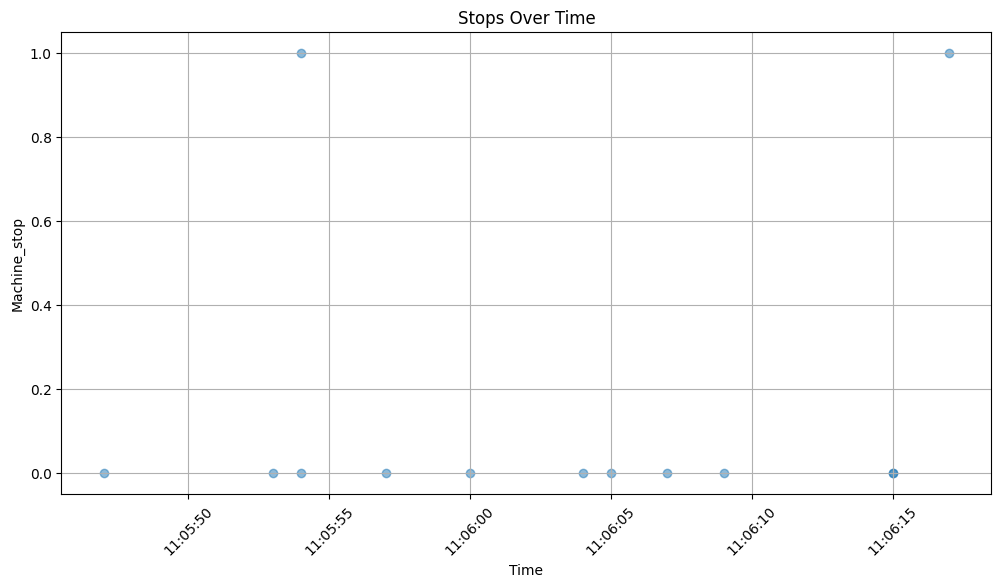

In [86]:
plot_scatter(snapshot_df[snapshot_df['snapshot'] == 15], 'Machine_stop', title="Stops Over Time")